# Quantum Nearest Neighbors

____________

In this Notebook, I implement the algorithm introduced in [this paper](https://arxiv.org/pdf/1412.3646.pdf) by [Maria Schuld](https://scholar.google.com/citations?user=_ih_hwUAAAAJ&hl=en), [Ilya Sinayskiy](https://scholar.google.co.za/citations?user=tL1_WfsAAAAJ&hl=en) and [Francesco Petruccione](https://scholar.google.com/citations?user=chM4fT4AAAAJ&hl=en).

See [this notebook](./quantum-nearest-neighbors_theory.ipynb) for details about the algorithm and the kind of problems it addresses.

In this implementation, I construct the model for arbitrary dataset size $N$ and dimension $n$, and focus on binary classification. The elements of the algorithm are encapsulated in functions.

Test cases are provided in the end, but if one wishes to visualize intermediate steps, please see [this implementation](./quantum-nearest-neighbors_particular.ipynb) of a particular $N=n=4$ case, in which all details are discussed, and analytical computations are provided.

____________

In [1]:
import numpy as np
from scipy.linalg import expm

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute

from qiskit.circuit import AncillaQubit

from qiskit.visualization import plot_histogram

from qiskit.circuit.library.standard_gates import XGate, ZGate, HGate

from qiskit.circuit.add_control import add_control

from qiskit.extensions import UnitaryGate

In [2]:
import matplotlib.pyplot as plt

def show_figure(fig):
    '''
    auxiliar function to display plot 
    even if it's not the last command of the cell
    from: https://github.com/Qiskit/qiskit-terra/issues/1682
    '''
    
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)

In [3]:
def test_circuit(qc):
    ''' 
    auxiliar function, to test intermediate steps, looking at measurement results
    this function allows the inspection of the amplitudes of states, 
    at any point of the circuit (call it with the desired circuit)
    '''
    
    cr = ClassicalRegister(qc.num_qubits, "creg_test")
    qc_cr = QuantumCircuit(cr)

    qc_test = qc + qc_cr

    for i in range(qc.num_qubits):
        qc_test.measure(i, i)

    #################################

    backend = Aer.get_backend("qasm_simulator")

    job = execute(qc_test, backend, shots=1e5, seed_simulator=42)
    results = job.result()
    counts = results.get_counts()

    return plot_histogram(counts, title="Results", figsize=(12, 4))

_________

## Step 0 - state preparation

__Input vector (to be classified)__

Construct $\left | \vec{x} \right > = \left |x_1 \cdots x_n\right > , x_k \in \{0,1\}$.

In [4]:
def construct_input_state(X_test):
    '''
    construct quantum state from bit string X_test
    '''

    # number of features
    n = len(X_test)

    # build the circuit
    
    qr_input = QuantumRegister(n, "features_input")
    qc_input = QuantumCircuit(qr_input)

    for i in range(n):
        if X_test[i] == "1":
            qc_input.x(i)
        
    return qc_input

______

__Training set__

Construct $ \left | T \right > = \frac{1}{\sqrt{N}} \sum_{p=1}^N \left |\vec{v}^p, c^p \right >  $ for binary classification ($c^p \in \{0, 1\}$)

In [5]:
def construct_training_set_state(X, y):
    '''
    construct quantum superposition of training dataset from:
    - X: feature matrix
    - y: target array
    returns the circuit as well as the number of features, n
    '''
    
    # number of examples
    N = X.shape[0]

    # number of features
    n = X.shape[1]

    # full dataset, of the form [[X], [y]]
    dataset = np.append(X, y.reshape((-1, 1)), axis=1)
    
    # n+1 because the last register will encode the class!
    amplitudes = np.zeros(2**(n+1))
    
    # integer representation of binary strings in training dataset
    # notice the [::-1], which is necessary to adjust the endianness!
    data_points_X = [int("".join(str(i) for i in X[j])[::-1], 2) for j in range(dataset.shape[0])]
    
    # integer representation considering also the class
    # IMPORTANT: sum 2**n for elements in class 1
    # this is necessary to encode also the class, in n+1 registers!
    data_points = [x + 2**n if y[i] == 1 else x for i, x in enumerate(data_points_X)]
    
    # set amplitudesof existing datapoints
    amplitudes[data_points] = 1
    
    # normalize amplitudes
    amplitudes = amplitudes/np.sqrt(amplitudes.sum())
    
    ###################################################
    
    # build the circuit
    
    qr_features = QuantumRegister(n, "features_train")
    qr_target = QuantumRegister(1, "target_train")

    qc_training = QuantumCircuit(qr_features, qr_target)

    qc_training.initialize(amplitudes, [qr_features, qr_target])
        
    return qc_training, n

__________

__Ancilla__

Add an ancilla register initialized as $\left | 0 \right >$

In [6]:
def construct_ancilla_state():
    '''
    construct ancilla register
    '''
    
    # build the circuit
    
    qr_anc = QuantumRegister(1, "anc")
    qc_anc = QuantumCircuit(qr_anc)

    qc_anc.draw("mpl")
        
    return qc_anc

_________


__Full circuit for initial state $\left | \psi_0 \right >$__

Construct $ \left | \psi_0 \right > = \frac{1}{\sqrt{N}} \sum_{p=1}^N \left |\vec{x}, \vec{v}^p, c^p \right > \otimes \left | 0 \right > $

In [7]:
def construct_initial_state(X, y, X_test, draw=False):
    '''
    conjugate elements of the initial state (input, training dataset and ancilla) in a
    single quantum circuit
    returns the circuit as well as the number of features, n
    '''
    
    qc_input = construct_input_state(X_test)
    
    qc_training, n = construct_training_set_state(X, y)
    
    qc_anc = construct_ancilla_state()
    
    qc = qc_input + qc_training + qc_anc

    qc.barrier()

    if draw:
        print("\nInitial state:")
        show_figure(qc.draw("mpl"))
    
    return qc, n

_________

## Quantum algorithm

__Step 1: ancilla in superposition__

$ \left | \psi_1 \right > = H_{\text{anc}} \left | \psi_0 \right > $

In [8]:
def step1(qc, draw=False):
    
    qc.h(-1)

    qc.barrier()

    if draw:
        print("\nStep 1:")
        show_figure(qc.draw("mpl"))
        
    return qc

__Step 2: hamming distance into the second register__

$ \left | \psi_2 \right > = \prod_{k=1}^{n=4} \mathrm{cNOT}(x_k, v^p_k) \left | \psi_1 \right >$

In [9]:
def step2(qc, n, draw=False):
    
    for i in range(n):

        qc.cnot(i, n+i)

    qc.barrier()

    if draw:
        print("\nStep 2:")
        show_figure(qc.draw("mpl"))
        
    return qc

__Step 3: hamming distance extracted to phase__

$ U = e^{ -i\frac{\pi }{2n} H}  \ ; \qquad\; H = 1 \otimes \sum_{k=1}^n \left(\frac{1-\sigma_z}{2}\right)_{d_k}  \otimes 1 \otimes \sigma_z \ ; $


$ \left | \psi_3 \right > = U \left | \psi_2 \right >$



Notice that $H$ is defined in terms of operators acting in each one of the 4 "registers" (input, train/hamming distance, class, ancilla).

Let's write the (single-qubit) unitaries which will be applied to each qubit of the respective register.

__UPDATE__: actually, we can extract the Hamming distance to the exponential phase by applying:

- $e^{  U_1^-} \ ; U_1^- = -i\frac{\pi }{2n} \sum_{k=1}^n \left(\frac{1-\sigma_z}{2}\right)_{d_k}$ to the second register if the ancilla is $\left | 0 \right >$ ; 

- $e^{ U_1^+} \ ; U_1^+ = i\frac{\pi }{2n} \sum_{k=1}^n \left(\frac{1-\sigma_z}{2}\right)_{d_k}$ to the second register if the ancilla is $\left | 1 \right >$ ; 

We do this with controlled unitaries (control: ancillar; target: respective registers)! Let's build them below.

In [10]:
def step3(qc, n, draw):
    
    # matrices of 1 and \sigma_z to be exponentiated below
    # source of the matrix exponential methods below:
    # https://quantumcomputing.stackexchange.com/questions/10317/quantum-circuit-to-implement-matrix-exponential

    idtt = np.eye(2)

    sz = np.array([[1,0], 
                   [0,-1]])
    
    ###################################################
    
    # define the exponentiated unitaries
    U_1_minus = expm(-1j * (np.pi/(2*4)) * ((idtt-sz)/2))
    U_1_plus = expm(1j * (np.pi/(2*4)) * ((idtt-sz)/2))

    # defining controlled gates
    u1m = add_control(operation=UnitaryGate(U_1_minus, label="$U_1^-$"),
                      num_ctrl_qubits=1, ctrl_state=0, label="$CU_1^-$")

    u1p = add_control(operation=UnitaryGate(U_1_plus, label="$U_1^+$"),
                      num_ctrl_qubits=1, ctrl_state=1, label="$CU_1^+$")


    # getting the registers
    registers = qc.qregs
    
    # register labels
    registers_labels = [qr.name for qr in qc.qregs]

    qr_features = registers[registers_labels.index("features_train")]
    qr_anc = registers[registers_labels.index("anc")]
    
    # build a circuit to apply the unitary above
    # this will be combined with the main circuit later on (notice: same registers!!).
    qc_u = QuantumCircuit(qr_features, qr_anc)

    for i in range(n):

        # apply the unitaries
        qc_u.append(u1p, [qr_anc[0], qr_features[i]])
        qc_u.append(u1m, [qr_anc[0], qr_features[i]])
    
    ###################################################
    
    # combine the U circuit above to the main circuit
    qc = qc.combine(qc_u)

    qc.barrier()
    
    ###################################################
    
    if draw:
        print("\nStep 3:")
        show_figure(qc.draw("mpl"))
        
    return qc

__Step 4: ancilla in superposition__

$ \left | \psi_4 \right > = H_{\text{anc}} \left | \psi_3 \right >$

In [11]:
def step4(qc, draw):
    
    qc.h(-1)

    qc.barrier()

    if draw:
        print("\nStep 4:")
        show_figure(qc.draw("mpl"))
        
    return qc

_________

## Step 5 - Measurement

Now, it's convenient to write $\left | \psi_4 \right >$ as

$\left |\psi_4\right > = \frac{1}{\sqrt{N}} \sum \limits_{c=1}^d \left |c\right > \otimes \sum \limits_{l\in c} \left ( \mathrm{cos}\left( \frac{\pi d_H}{2n}\right)  \left |\vec{x};\vec{d}^l; 0\right > +  \mathrm{sin}\left( \frac{\pi d_H}{2n}\right)  \left |\vec{x};\vec{d}^l; 1\right > \right ) . $

First, we measure the ancilla qubit; then, the class qubit.

The probability of measuring the ancilla qubit to be in $\left | 0 \right >$ is

$ P(\left | 0 \right >_a) = \left |   \left < 0 | \psi_4 \right >  \right |^2 =  \frac{1}{N} \sum_{p=1}^{N=4}  \cos^2\left (\frac{\pi d_H}{2n} \right)$

The probability of measuring the qubit in a given class $c$, given that the ancilla was beasured to be in $\left | 0 \right >$, is

$P(c) =  \frac{1}{ P(\left | 0 \right >_a)}\frac{1}{N} \sum \limits_{l\in c} \cos^2\left (\frac{\pi d_H}{2n} \right) = \frac{1}{2} \sum \limits_{l\in c} \cos^2\left (\frac{\pi d_H}{2n} \right) \ , $


In [12]:
def measurement(qc, draw_final):
    '''
    implements the measurement of the circuit
    '''
    
    # getting the registers
    registers = qc.qregs
    registers_labels = [qr.name for qr in qc.qregs]

    qr_anc = registers[registers_labels.index("anc")]
    qr_target = registers[registers_labels.index("target_train")]
    
    ###########################3
    
    cr_anc = ClassicalRegister(1, "c_anc")
    qc_cr_anc = QuantumCircuit(cr_anc)

    cr_class = ClassicalRegister(1, "c_class")
    qc_cr_class = QuantumCircuit(cr_class)

    qc = qc + qc_cr_anc + qc_cr_class

    qc.measure(qr_anc, cr_anc)
    qc.measure(qr_target, cr_class)

    if draw_final:
        print("\nStep 5 (measurement):")
        show_figure(qc.draw("mpl"))
        
    return qc

__Finally, execution and final answer__

In [13]:
def run(qc):
    '''
    runs the circuit, display results and return both
    predicted class and probability distribution of prediction
    '''

    backend = Aer.get_backend("qasm_simulator")
    
    n_shots = 1e4

    job = execute(qc, backend, shots=n_shots, seed_simulator=42)
    results = job.result()
    counts = results.get_counts()

    # filtering out measurements of ancila = |1> (last register)
    keys = list(counts.keys()).copy()
    for key in keys:

        if key[-1] == "1":

            counts.pop(key)

    show_figure(plot_histogram(counts, title="Results", figsize=(12, 4)))

    ####################################
    # final prediction
    
    # dictionary of counts sorted by value (sbv), decreasing order...
    counts_sbv = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

    # ...will have its first key (first [0]) corresponding to the class with highest count (thus, probability!)
    # the key is of the form "class ancilla", thus, to get the actual class, get the first character (second [0])
    y_pred = list(counts_sbv.keys())[0][0]

    # also display probabilities (predict_proba)
    n_norm = sum(list(counts.values()))
    y_proba = {"p(c={})".format(classe[0]): count/n_norm for classe, count in counts_sbv.items()}
    
    print("\nProbability of belonging to each class:\n")
    
    for k, v in y_proba.items():
        
        print("{} = {:.3f}".format(k, v))
    
    print("\n")
    print("*"*30)
    print("="*30)
    print("*"*30)
    print("\n")
    
    print("Final prediction:\n")
    print("y({}) = {}".format(X_test, y_pred))
    
    return y_pred, y_proba

______

__Combining all steps in a single function__

In [14]:
def quantum_nearest_neighbors(qc, n, X_test, draw=False, draw_final=False):
    
    qc = step1(qc, draw)
    
    qc = step2(qc, n, draw)
    
    qc = step3(qc, n, draw)
    
    qc = step4(qc, draw)
    
    qc = measurement(qc, draw_final)
    
    y_pred, y_proba = run(qc)
    
    return y_pred, y_proba 

________
________
________

### Let's test the algorithm!

First, the same case implemented in the other notebook (the particular $N=n=4$ case, with balanced classes)

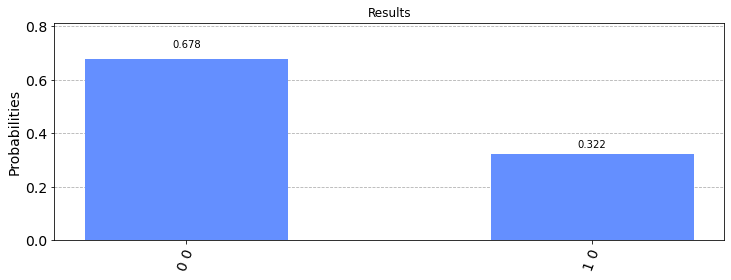


Probability of belonging to each class:

p(c=0) = 0.678
p(c=1) = 0.322


******************************
******************************


Final prediction:

y(0010) = 0


('0', {'p(c=0)': 0.6781312127236581, 'p(c=1)': 0.32186878727634194})

In [15]:
X = np.array([[0, 0, 0, 0],
              [0, 0, 0, 1],
              [1, 1, 1, 0],
              [1, 1, 1, 1]])

# balanced
y = np.array([0, 0, 1, 1])

#############################################

X_test = "0010"

#############################################

qc, n = construct_initial_state(X, y, X_test)

quantum_nearest_neighbors(qc, n, X_test)

_____________

Now, a larger, imbalanced case ($N=n=5$)

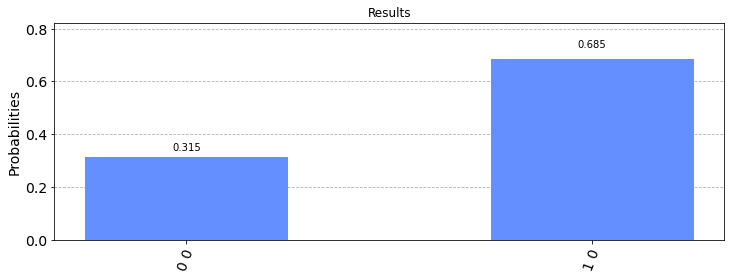


Probability of belonging to each class:

p(c=1) = 0.685
p(c=0) = 0.315


******************************
******************************


Final prediction:

y(10101) = 1


('1', {'p(c=1)': 0.685126582278481, 'p(c=0)': 0.314873417721519})

In [16]:
X = np.array([[0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 0, 1, 1],
              [1, 1, 1, 1, 0],
              [1, 1, 1, 1, 1]])

# imbalanced
y = np.array([0, 0, 0, 1, 1])

#############################################

X_test = "10101"

#############################################

qc, n = construct_initial_state(X, y, X_test)

quantum_nearest_neighbors(qc, n, X_test)

Result makes sense! `10101` indeed seems to belong to class 1

________

Finally, a more complicated, assymetric and imbalanced case ($N=5$, $n=6$)

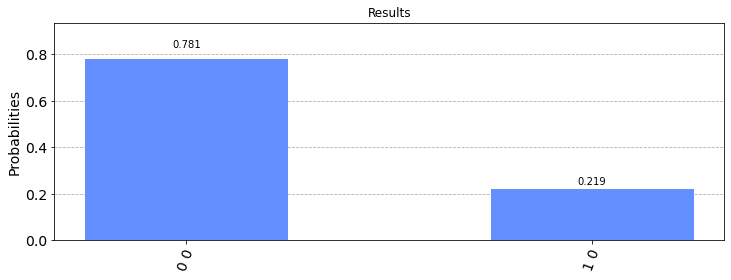


Probability of belonging to each class:

p(c=0) = 0.781
p(c=1) = 0.219


******************************
******************************


Final prediction:

y(001111) = 0


('0', {'p(c=0)': 0.7807118254879449, 'p(c=1)': 0.21928817451205512})

In [17]:
X = np.array([[0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 1],
              [0, 0, 0, 1, 1, 0],
              [1, 1, 1, 1, 0, 1],
              [1, 1, 1, 1, 1, 0]])

# imbalanced
y = np.array([0, 0, 0, 1, 1])

#############################################

X_test = "001111"

#############################################

qc, n = construct_initial_state(X, y, X_test)

quantum_nearest_neighbors(qc, n, X_test)

This one took a bit longer to run, but also yielded a reasonable result! The test point `001111` indeed does seem to belong to class 0! Nice!

___________


Let's try a more ambiguous test point...

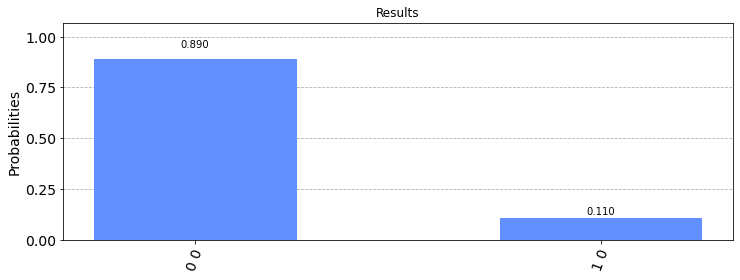


Probability of belonging to each class:

p(c=0) = 0.890
p(c=1) = 0.110


******************************
******************************


Final prediction:

y(001100) = 0


('0', {'p(c=0)': 0.8900596421471173, 'p(c=1)': 0.1099403578528827})

In [18]:
# modified dataset to cause ambiguity 
# (notice how many examples have the central "11")
X = np.array([[0, 0, 0, 0, 0, 0],
              [0, 0, 1, 1, 0, 1],
              [0, 0, 1, 1, 1, 0],
              [1, 1, 1, 1, 0, 1],
              [1, 1, 1, 1, 1, 0]])

# imbalanced
y = np.array([0, 0, 0, 1, 1])

#############################################

X_test = "001100"

#############################################

qc, n = construct_initial_state(X, y, X_test)

quantum_nearest_neighbors(qc, n, X_test)

It's pretty confident on class 0... Maybe it's because of the class imbalance...

Let's try the same ambiguity, but adding another observation to balance the classes:

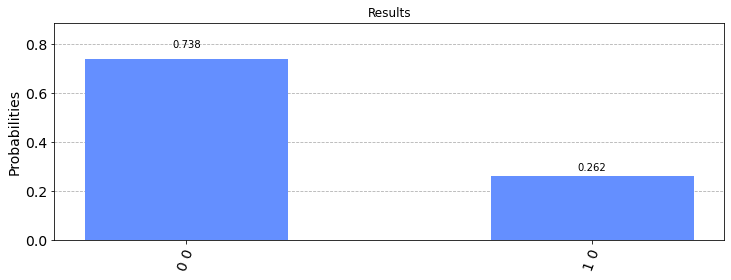


Probability of belonging to each class:

p(c=0) = 0.738
p(c=1) = 0.262


******************************
******************************


Final prediction:

y(001100) = 0


('0', {'p(c=0)': 0.7377733598409543, 'p(c=1)': 0.26222664015904573})

In [19]:
# modified dataset to cause ambiguity 
# (notice how many examples have the central "11")
X = np.array([[0, 0, 0, 0, 0, 0],
              [0, 0, 1, 1, 0, 1],
              [0, 0, 1, 1, 1, 0],
              [1, 1, 1, 1, 0, 1],
              [1, 1, 1, 1, 1, 0],
              [1, 1, 0, 0, 1, 1]])

# imbalanced
y = np.array([0, 0, 0, 1, 1, 1])

#############################################

X_test = "001100"

#############################################

qc, n = construct_initial_state(X, y, X_test)

quantum_nearest_neighbors(qc, n, X_test)

It's still pretty confident on class 0, but the probability dropped, given the modification in the dataset. Interesting!

___________